<a href="https://colab.research.google.com/github/icapucap/SE_project/blob/main/vgg_cifar_10_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8MB 4.2MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 163kB 42.3MB/s 
     |████████████████████████████████| 102kB 11.4MB/s 
     |████████████████████████████████| 133kB 41.9MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=8a044cf4e3656a4e3eeda226db488425c22f9922fa734bbd7510e0b19a8b6d7f
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=e5e717571bf520bf596388c9b4f21d98dbadb3d0a7e43a68c6f03be9ee7b2f97
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=a4b8a82adffa4647827c38fa12c48f9acb4be024cddf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD,Adam
from keras.layers import Activation, AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import glorot_normal
from keras.utils import np_utils
from keras import backend as K
from keras.datasets import cifar10
from keras.callbacks import  EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.optimizers.schedules import ExponentialDecay
from keras.metrics import AUC
from keras.utils.vis_utils import plot_model

In [ ]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="vgg-cifar10_nin")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
# data loading and preprocessing

batch_size = 128
epochs = 50
learning_rate = 0.05
lr_decay = 1e-6
lr_drop = 20
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train  /= 255
x_test /= 255

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
               
datagen = ImageDataGenerator(
            featurewise_center=False, 
            samplewise_center=False,  
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False,  
            zca_whitening=False,  
            rotation_range=15,  
            width_shift_range=0.1,  
            height_shift_range=0.1,  
            horizontal_flip=True, 
            vertical_flip=False)  
      
datagen.fit(x_train)


170500096/170498071 [==============================] - 3s 0us/step


In [7]:
BATCH_NORM = True
num_classes=10


In [5]:

def base_model_with_nin():

    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:], name='block1_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (1, 1), padding='same', name='block1_conv2nin1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (1, 1), padding='same', name='block1_conv2nin2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (1, 1), padding='same', name='block1_conv2nin3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (1, 1), padding='same', name='block2_conv2nin1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (1, 1), padding='same', name='block2_conv2nin2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (1, 1), padding='same', name='block2_conv2nin3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (1, 1), padding='same', name='block3_conv2nin1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (1, 1), padding='same', name='block3_conv3nin2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (1, 1), padding='same', name='block3_conv4nin3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (1, 1), padding='same', name='block4_conv2nin1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (1, 1), padding='same', name='block4_conv3nin2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (1, 1), padding='same', name='block4_conv4nin3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (1, 1), padding='same', name='block5_conv2nin1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (1, 1), padding='same', name='block5_conv3nin2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (1, 1), padding='same', name='block5_conv4nin3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(10, (1, 1), padding='same', name='block5_convlast' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))


    model.add(GlobalAveragePooling2D())

    model.add(Activation('softmax'))

    # sgd = SGD(lr=learning_rate, decay=lr_decay, momentum=0.75, nesterov=True)
    lr_schedule = ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=10000,
    decay_rate=0.85)
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy',AUC()])
    return model







Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_51 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_52 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_52 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_53 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)       

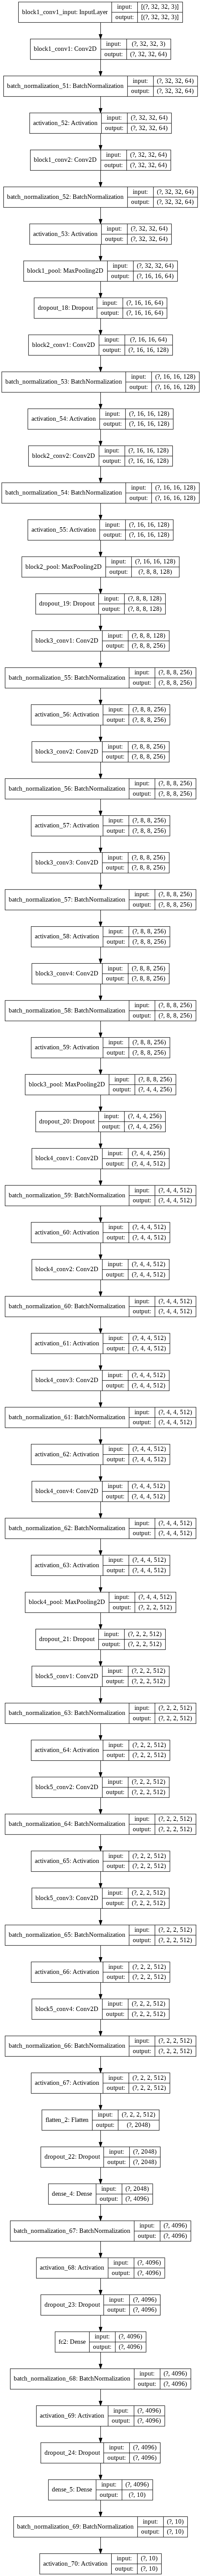

In [11]:
# prints model summary and also stores the same as an image in png format

cnn_n = base_model_with_nin()
cnn_n.summary()
plot_model(cnn_n, to_file='nin.png', show_shapes=True, show_layer_names=True)

In [ ]:
cnn_n.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),callbacks=[WandbCallback(data_type="image", validation_data=(x_test, y_test), labels=class_names),
                               EarlyStopping(monitor='val_accuracy',patience=5, restore_best_weights=True)],verbose=2)
#cnn_n.save_weights('cifar10vgg.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_42 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_44 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv2nin1 (Conv2D)    (None, 32, 32, 64)        4160      
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_45 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv2nin2 (Conv2D)    (None, 32, 32, 64)       

313/313 - 3s
0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[ 991    0    0    0    0    0    0    0    0    9]
 [ 863    0    0    0    0    0    0    0    0  137]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [ 983    0    0    0    0    0    0    0    0   17]
 [ 905    0    0    0    0    0    0    0    0   95]]


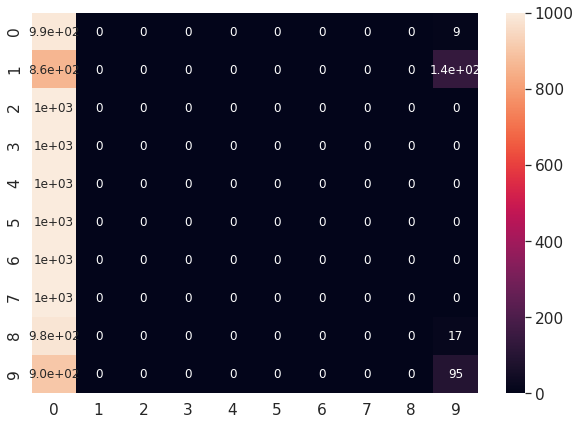

In [ ]:


from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn_n.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()